Github Repository:
https://github.com/Kyunianti19/jala_assignment_test

In [140]:
# Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression


# Survival Rate (SR) Calculation per Cultivation Cycle

\begin{equation}
survival\;rate=\frac{harvested\;shrimp}{seed\;shrimp}
\end{equation}

Data completeness:
- Total seed shrimp can be obtained from "cycle dataset"
- Unfortunately, there's no data for harvested shrimp in "harvest dataset"

On the other hand we have mortality data. Assuming that the mortality data record all number of death shrimps, the equation above can be modified into:

\begin{equation}
survival\;rate=\frac{seed\;shrimp-mortality\;shrimp}{seed\;shrimp}
\end{equation}

In [61]:
df_cycle = pd.read_csv('Data/cycles.csv')
df_cycle = df_cycle[['id', 'pond_id', 'started_at', 'finished_at', 'total_seed']].copy()
# Rename columns & change data type
df_cycle.columns = ['cycle_id', 'pond_id', 'start_date', 'finish_date', 'total_seed_shrimp']
df_cycle.start_date = pd.to_datetime(df_cycle.start_date)
df_cycle.finish_date = pd.to_datetime(df_cycle.finish_date)
# Drop duplicates and null rows
df_cycle = df_cycle.drop_duplicates()
df_cycle = df_cycle.dropna(subset=['cycle_id', 'start_date', 'finish_date', 'total_seed_shrimp'])

df_harvest = pd.read_csv('Data/harvests.csv')
df_harvest = df_harvest[['cycle_id', 'harvested_at', 'status']].copy()
# Rename columns & change data type
df_harvest.columns = ['cycle_id', 'harvest_date', 'harvest_status']
df_harvest.harvest_date = pd.to_datetime(df_harvest.harvest_date)
df_harvest.cycle_id = df_harvest.cycle_id.astype(int)
# Drop duplicates and null rows
df_harvest = df_harvest.drop_duplicates()
df_harvest = df_harvest.dropna(subset=['cycle_id', 'harvest_date', 'harvest_status'])

df_mortalities = pd.read_csv('Data/mortalities.csv')
df_mortalities = df_mortalities[['cycle_id', 'recorded_at', 'quantity']].copy()
# Rename columns & change data type
df_mortalities.columns = ['cycle_id', 'record_date', 'total_mortality_shrimp']
df_mortalities.record_date = pd.to_datetime(df_mortalities.record_date)
# Drop duplicates and null rows
df_mortalities = df_mortalities.drop_duplicates()
df_mortalities = df_mortalities.dropna(subset=['cycle_id', 'record_date', 'total_mortality_shrimp'])

In [62]:
# Count harvest
df_count_harvest = df_cycle[['cycle_id', 'start_date', 'finish_date']].merge(df_harvest[['cycle_id', 'harvest_date']], 
                                                                              how='inner', on=['cycle_id'])
df_count_harvest = df_count_harvest[(df_count_harvest.start_date<=df_count_harvest.harvest_date)&(df_count_harvest.finish_date>=df_count_harvest.harvest_date)]
df_count_harvest = df_count_harvest.drop_duplicates()
df_count_harvest = df_count_harvest.groupby(['cycle_id', 'start_date', 'finish_date']).count().reset_index()
df_count_harvest.columns = ['cycle_id', 'start_date', 'finish_date', 'harvest_times']
# Join cycle & harvest
df_cycle_harvest = df_cycle.merge(df_harvest[df_harvest.harvest_status=='Full'], 
                                  how='inner', left_on=['cycle_id', 'finish_date'], right_on=['cycle_id', 'harvest_date'])
df_cycle_harvest = df_cycle_harvest.merge(df_count_harvest, how='left', on=['cycle_id', 'start_date', 'finish_date'])
df_cycle_harvest = df_cycle_harvest.drop(columns='harvest_date')
df_cycle_harvest

,cycle_id,pond_id,start_date,finish_date,total_seed_shrimp,harvest_status,harvest_times
0,18876,36294,2022-10-14,2023-01-29,331920,Full,1
1,22118,37102,2023-04-26,2023-06-23,40000,Full,2
2,24088,39154,2023-08-01,2023-10-18,357570,Full,2
3,17743,20914,2022-07-19,2022-09-29,168275,Full,2
4,17125,34187,2022-07-07,2022-09-20,188000,Full,1
...,...,...,...,...,...,...,...
2134,24771,42826,2023-08-10,2023-11-13,226284,Full,3
2135,19131,34712,2022-10-25,2023-01-21,300000,Full,1
2136,27552,45697,2023-11-05,2024-02-13,100000,Full,2
2137,15868,32398,2022-04-28,2022-06-21,150000,Full,1


In [70]:
# Count Mortality
df_count_mortality = df_cycle[['cycle_id', 'start_date', 'finish_date']].merge(df_mortalities, 
                                                                               how='inner', on=['cycle_id'])
df_count_mortality = df_count_mortality[(df_count_mortality.start_date<=df_count_mortality.record_date)&(df_count_mortality.finish_date>=df_count_mortality.record_date)]
df_count_mortality = df_count_mortality.drop_duplicates()
df_count_mortality = df_count_mortality.drop(columns='record_date').groupby(['cycle_id', 'start_date', 'finish_date']).sum().reset_index()
# Join cycle & harvest & mortality
df_cycle_harvest_mortality = df_cycle_harvest.merge(df_count_mortality, how='left', on=['cycle_id', 'start_date', 'finish_date'])
df_cycle_harvest_mortality

,cycle_id,pond_id,start_date,finish_date,total_seed_shrimp,harvest_status,harvest_times,total_mortality_shrimp
0,18876,36294,2022-10-14,2023-01-29,331920,Full,1,33957.0
1,22118,37102,2023-04-26,2023-06-23,40000,Full,2,NaN
2,24088,39154,2023-08-01,2023-10-18,357570,Full,2,23355.0
3,17743,20914,2022-07-19,2022-09-29,168275,Full,2,11766.0
4,17125,34187,2022-07-07,2022-09-20,188000,Full,1,54.0
...,...,...,...,...,...,...,...,...
2134,24771,42826,2023-08-10,2023-11-13,226284,Full,3,24362.0
2135,19131,34712,2022-10-25,2023-01-21,300000,Full,1,NaN
2136,27552,45697,2023-11-05,2024-02-13,100000,Full,2,1800.0
2137,15868,32398,2022-04-28,2022-06-21,150000,Full,1,4981.0


In [71]:
df_cycle_harvest_mortality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cycle_id                2139 non-null   int64         
 1   pond_id                 2139 non-null   int64         
 2   start_date              2139 non-null   datetime64[ns]
 3   finish_date             2139 non-null   datetime64[ns]
 4   total_seed_shrimp       2139 non-null   int64         
 5   harvest_status          2139 non-null   object        
 6   harvest_times           2139 non-null   int64         
 7   total_mortality_shrimp  744 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 133.8+ KB


In [72]:
# Drop null rows - Only calculate SR for shrimp cycle that have mortality record & harvest status = Full (finish)
df_cycle_harvest_mortality = df_cycle_harvest_mortality.dropna(subset=['total_mortality_shrimp'])
# Validate data: total_mortality_shrimp must be less than or equal to total_seed_shrimp
df_cycle_harvest_mortality = df_cycle_harvest_mortality[df_cycle_harvest_mortality.total_seed_shrimp >= df_cycle_harvest_mortality.total_mortality_shrimp]
df_cycle_harvest_mortality

,cycle_id,pond_id,start_date,finish_date,total_seed_shrimp,harvest_status,harvest_times,total_mortality_shrimp
0,18876,36294,2022-10-14,2023-01-29,331920,Full,1,33957.0
2,24088,39154,2023-08-01,2023-10-18,357570,Full,2,23355.0
3,17743,20914,2022-07-19,2022-09-29,168275,Full,2,11766.0
4,17125,34187,2022-07-07,2022-09-20,188000,Full,1,54.0
6,26058,44147,2023-10-02,2024-03-03,148007,Full,7,19897.0
...,...,...,...,...,...,...,...,...
2127,21687,38743,2023-04-06,2023-06-10,228344,Full,1,31080.0
2133,25362,43578,2023-10-16,2024-01-31,221000,Full,3,6424.0
2134,24771,42826,2023-08-10,2023-11-13,226284,Full,3,24362.0
2136,27552,45697,2023-11-05,2024-02-13,100000,Full,2,1800.0


In [74]:
# Calculate SR
df_cycle_harvest_mortality['survival_rate'] = 1 - df_cycle_harvest_mortality['total_mortality_shrimp'] / df_cycle_harvest_mortality['total_seed_shrimp']
# Save the final data calculation
df_cycle_harvest_mortality.to_csv('SR_calculation.csv', index=False)

In [75]:
df_cycle_harvest_mortality.survival_rate.describe()

count    738.000000
mean       0.924317
std        0.111871
min        0.034534
25%        0.910319
50%        0.967140
75%        0.990451
max        0.999997
Name: survival_rate, dtype: float64

<Axes: xlabel='survival_rate', ylabel='Count'>

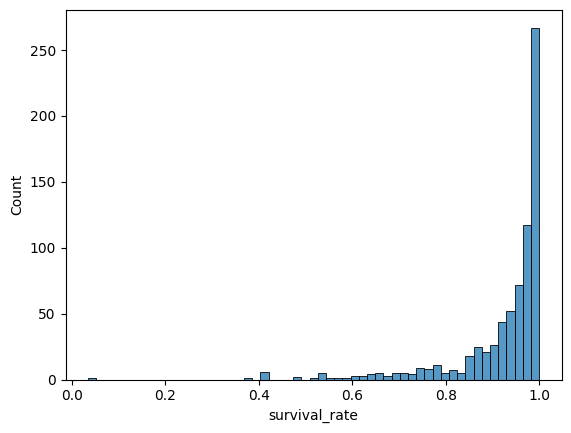

In [76]:
sns.histplot(df_cycle_harvest_mortality, x="survival_rate")

Summary
- The median survival rate is 96.7%

Note:
- Assuming all the shrimp mortality are fully recorded in the data

# Average Growth Rate per Cultivation Cycle

\begin{equation}
average\;growth\;rate=\frac{delta\;weight}{delta\;cultivation\;days}
\end{equation}

Data completeness:
- Delta weight and cultivation days can be obtained from "sampling data"

By ploting the weight (y-axis) and days (x-axis), the average growth rate can be estimated by the gradient of the formed line (linear regression)

In [126]:
df_cycle = pd.read_csv('Data/cycles.csv')
df_cycle = df_cycle[['id', 'pond_id', 'started_at', 'finished_at']].copy()
# Rename columns & change data type
df_cycle.columns = ['cycle_id', 'pond_id', 'start_date', 'finish_date']
df_cycle.start_date = pd.to_datetime(df_cycle.start_date)
df_cycle.finish_date = pd.to_datetime(df_cycle.finish_date)
# Drop duplicates and null rows
df_cycle = df_cycle.drop_duplicates()
df_cycle = df_cycle.dropna(subset=['cycle_id', 'start_date', 'finish_date'])

df_sampling = pd.read_csv('Data/samplings.csv')
df_sampling = df_sampling[['cycle_id', 'sampled_at', 'average_weight']].copy()
# Rename columns & change data type
df_sampling.columns = ['cycle_id', 'sampled_date', 'average_weight']
df_sampling = df_sampling[df_sampling.sampled_date!='1-01-01']
df_sampling.sampled_date = pd.to_datetime(df_sampling.sampled_date)
df_sampling.cycle_id = df_sampling.cycle_id.astype(int)
# Drop duplicates and null rows
df_sampling = df_sampling.drop_duplicates()
df_sampling = df_sampling.dropna(subset=['cycle_id', 'sampled_date', 'average_weight'])

# Join Data Frame
df_cycle_sampling = df_sampling.merge(df_cycle, how='inner', on=['cycle_id'])
# Validate the sampling between cycle start & finish date
df_cycle_sampling = df_cycle_sampling[(df_cycle_sampling.start_date<=df_cycle_sampling.sampled_date)&(df_cycle_sampling.finish_date>=df_cycle_sampling.sampled_date)]

# Calculate count sampling (average growth rate can only be calculated if there's at least 2 number of observations)
df_count_sampling = df_cycle_sampling[['cycle_id', 'sampled_date']].groupby('cycle_id').count().reset_index()
df_count_sampling = df_count_sampling[df_count_sampling.sampled_date > 1]

# Final data sampling
df_cycle_sampling = df_cycle_sampling.merge(df_count_sampling[['cycle_id']], how='inner', on=['cycle_id'])
df_cycle_sampling = df_cycle_sampling.sort_values(by=['cycle_id', 'sampled_date'])
# Calculate delta cultivation days
df_cycle_sampling['delta_days'] = (df_cycle_sampling['sampled_date'] - df_cycle_sampling['start_date']).dt.days
df_cycle_sampling

,cycle_id,sampled_date,average_weight,pond_id,start_date,finish_date,delta_days
8304,3458,2020-04-10,4.37,12969,2020-03-07,2020-06-27,34
8305,3458,2020-04-17,5.23,12969,2020-03-07,2020-06-27,41
8303,3458,2020-04-24,6.69,12969,2020-03-07,2020-06-27,48
8302,3458,2020-05-01,8.21,12969,2020-03-07,2020-06-27,55
8306,3458,2020-05-08,9.68,12969,2020-03-07,2020-06-27,62
...,...,...,...,...,...,...,...
5469,29874,2024-02-20,4.10,43654,2024-01-09,2024-03-25,42
5470,29874,2024-02-27,6.20,43654,2024-01-09,2024-03-25,49
5471,29874,2024-03-05,8.39,43654,2024-01-09,2024-03-25,56
5472,29874,2024-03-12,8.98,43654,2024-01-09,2024-03-25,63


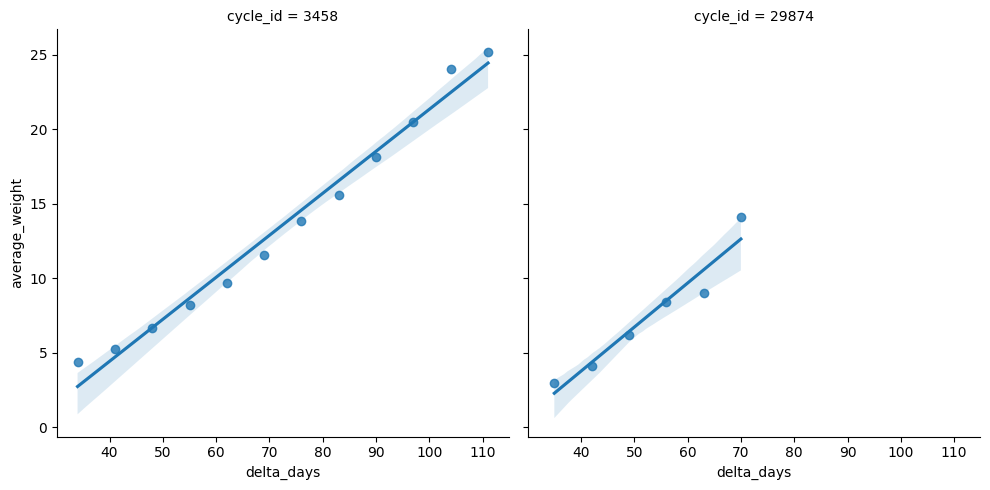

In [133]:
# Try to plot 2 cycle as sample for regression
sns.lmplot(data=df_cycle_sampling[(df_cycle_sampling.cycle_id==3458)|(df_cycle_sampling.cycle_id==29874)], 
           x="delta_days", y="average_weight", col="cycle_id")

As we can see in the plot above, the gradient line represent the growth rate of shrimp in each cycle

In [170]:
array_cycles = df_cycle_sampling.cycle_id.unique()
array_growth_rate = []
for ac in array_cycles:
    temp_row = []
    temp_df = df_cycle_sampling[df_cycle_sampling.cycle_id==ac].copy()
    X = temp_df.delta_days.values.reshape(-1,1)
    y = temp_df.average_weight.values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    temp_row = [ac, reg.coef_[0,0]]
    array_growth_rate.append(temp_row)
df_growth_rate = pd.DataFrame(array_growth_rate, columns=['cycle_id', 'average_growth_rate'])
df_growth_rate

,cycle_id,average_growth_rate
0,3458,0.282038
1,3459,0.282677
2,4038,0.276481
3,4039,0.251430
4,4044,0.264913
...,...,...
1898,29579,0.161628
1899,29619,0.186364
1900,29679,0.061000
1901,29873,0.258122


In [173]:
# Save the final data calculation
df_growth_rate.to_csv('Avg_Growth_Rate_calculation.csv', index=False)
df_growth_rate.average_growth_rate.describe()

count    1903.000000
mean        0.258965
std         0.123031
min        -0.166667
25%         0.192343
50%         0.252602
75%         0.312714
max         2.066667
Name: average_growth_rate, dtype: float64

<Axes: xlabel='average_growth_rate', ylabel='Count'>

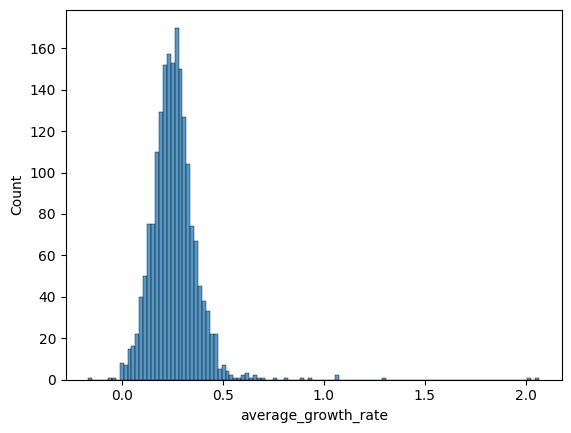

In [172]:
sns.histplot(df_growth_rate, x="average_growth_rate")

Summary
- The average growth rate is 0.25-0.26 grams per days


# Predictive: Survival Rate (SR) at pointed day

Assuming all the shrimp mortality are fully recorded in the data
\begin{equation}
survival\;rate=1-\frac{mortality\;shrimp}{seed\;shrimp}
\end{equation}

## Calculate SR

In [175]:
df_cycle = pd.read_csv('Data/cycles.csv')
df_cycle = df_cycle[['id', 'pond_id', 'started_at', 'finished_at', 'total_seed']].copy()
# Rename columns & change data type
df_cycle.columns = ['cycle_id', 'pond_id', 'start_date', 'finish_date', 'total_seed_shrimp']
df_cycle.start_date = pd.to_datetime(df_cycle.start_date)
df_cycle.finish_date = pd.to_datetime(df_cycle.finish_date)
# Drop duplicates and null rows
df_cycle = df_cycle.drop_duplicates()
df_cycle = df_cycle.dropna(subset=['cycle_id', 'start_date', 'finish_date', 'total_seed_shrimp'])

df_mortalities = pd.read_csv('Data/mortalities.csv')
df_mortalities = df_mortalities[['cycle_id', 'recorded_at', 'quantity']].copy()
# Rename columns & change data type
df_mortalities.columns = ['cycle_id', 'record_date', 'total_mortality_shrimp']
df_mortalities.record_date = pd.to_datetime(df_mortalities.record_date)
# Drop duplicates and null rows
df_mortalities = df_mortalities.drop_duplicates()
df_mortalities = df_mortalities.dropna(subset=['cycle_id', 'record_date', 'total_mortality_shrimp'])

In [208]:
# Count Mortality
df_count_mortality = df_cycle[['cycle_id', 'start_date', 'finish_date']].merge(df_mortalities, how='inner', on=['cycle_id'])
df_count_mortality = df_count_mortality[(df_count_mortality.start_date<=df_count_mortality.record_date)&(df_count_mortality.finish_date>=df_count_mortality.record_date)]
df_count_mortality = df_count_mortality.drop_duplicates()
df_count_mortality = df_count_mortality.sort_values(by=['cycle_id', 'record_date']).reset_index(drop=True)
df_count_mortality

,cycle_id,start_date,finish_date,record_date,total_mortality_shrimp
0,7273,2020-12-23,2021-03-27,2021-01-22,37400
1,7273,2020-12-23,2021-03-27,2021-02-05,2664
2,7273,2020-12-23,2021-03-27,2021-02-19,2125
3,7273,2020-12-23,2021-03-27,2021-03-05,1491
4,7276,2020-12-23,2021-03-27,2021-01-22,37400
...,...,...,...,...,...
13165,29450,2024-02-07,2024-03-17,2024-03-15,2600
13166,29450,2024-02-07,2024-03-17,2024-03-16,6500
13167,29579,2024-02-15,2024-03-26,2024-03-24,97
13168,29579,2024-02-15,2024-03-26,2024-03-25,1638


In [209]:
# Cumulative Sum of Mortality
array_ids = df_count_mortality[['cycle_id', 'record_date']].values
array_mortality = []
for id in array_ids:
    temp_row = []
    cumulative_sum = df_count_mortality[(df_count_mortality.cycle_id==id[0])&(df_count_mortality.record_date<=id[1])].total_mortality_shrimp.sum()
    temp_row = [id[0], id[1], cumulative_sum]
    array_mortality.append(temp_row)
df_sum_mortality = pd.DataFrame(array_mortality, columns=['cycle_id', 'record_date', 'total_mortality_shrimp'])
df_sum_mortality

,cycle_id,record_date,total_mortality_shrimp
0,7273,2021-01-22,37400
1,7273,2021-02-05,40064
2,7273,2021-02-19,42189
3,7273,2021-03-05,43680
4,7276,2021-01-22,37400
...,...,...,...
13165,29450,2024-03-15,2868
13166,29450,2024-03-16,9368
13167,29579,2024-03-24,97
13168,29579,2024-03-25,1735


In [213]:
# Survival Rate Calculation at certain day
df_SR = df_sum_mortality.merge(df_cycle[['cycle_id', 'pond_id', 'start_date', 'total_seed_shrimp']], how='inner', on=['cycle_id'])
# Validate total_mortality_shrimp must be less than pr equal to total_seed_shrimp
df_SR = df_SR[df_SR.total_seed_shrimp >= df_SR.total_mortality_shrimp]
df_SR['survival_rate'] = 1 - df_SR['total_mortality_shrimp'] / df_SR['total_seed_shrimp']
df_SR


,cycle_id,record_date,total_mortality_shrimp,pond_id,start_date,total_seed_shrimp,survival_rate
0,7273,2021-01-22,37400,19168,2020-12-23,75000,0.501333
1,7273,2021-02-05,40064,19168,2020-12-23,75000,0.465813
2,7273,2021-02-19,42189,19168,2020-12-23,75000,0.437480
3,7273,2021-03-05,43680,19168,2020-12-23,75000,0.417600
4,7276,2021-01-22,37400,19171,2020-12-23,75000,0.501333
...,...,...,...,...,...,...,...
13165,29450,2024-03-15,2868,45621,2024-02-07,195000,0.985292
13166,29450,2024-03-16,9368,45621,2024-02-07,195000,0.951959
13167,29579,2024-03-24,97,35864,2024-02-15,50000,0.998060
13168,29579,2024-03-25,1735,35864,2024-02-15,50000,0.965300


## Extract Features for Prediction

In [219]:
df_pond = pd.read_csv('Data/ponds.csv')
df_pond = df_pond[['id', 'length', 'width', 'deep']].copy()
# Rename columns & change data type
df_pond.columns = ['pond_id', 'length', 'width', 'deep']
df_pond['volume'] = df_pond['length'] * df_pond['width'] * df_pond['deep']
# Drop duplicates and null rows
df_pond = df_pond.drop_duplicates()
df_pond = df_pond.dropna(subset=['volume'])
df_pond

,pond_id,length,width,deep,volume
3,7,46.50,32.60,1.10,1667.4900
4,8,48.50,33.00,1.10,1760.5500
5,11,28.20,34.50,1.10,1070.1900
7,4,49.14,36.85,0.90,1629.7281
12,17565,28.00,12.00,1.55,520.8000
...,...,...,...,...,...
332,46700,46.00,34.00,1.50,2346.0000
333,44514,31.00,30.00,1.30,1209.0000
335,44579,21.00,14.00,1.30,382.2000
336,44613,40.00,40.00,1.50,2400.0000


In [242]:
df_feed = pd.read_csv('Data/feeds.csv')
df_feed = df_feed[['cycle_id', 'logged_at', 'quantity']].copy()
# # Rename columns & change data type
df_feed.columns = ['cycle_id', 'feed_datetime', 'feed_qty']
df_feed['feed_datetime'] = pd.to_datetime(df_feed['feed_datetime'])
df_feed['feed_date'] = pd.to_datetime(df_feed['feed_datetime'].dt.date)
# # Drop duplicates and null rows
df_feed = df_feed.drop_duplicates()
df_feed = df_feed.dropna()
df_feed = df_feed.sort_values(by=['cycle_id', 'feed_datetime']).reset_index(drop=True)
df_feed

,cycle_id,feed_datetime,feed_qty,feed_date
0,3458,2020-03-08 11:30:00,8.0,2020-03-08
1,3458,2020-03-09 11:30:00,20.0,2020-03-09
2,3458,2020-03-10 11:30:00,22.0,2020-03-10
3,3458,2020-03-11 11:30:00,24.0,2020-03-11
4,3458,2020-03-12 11:30:00,26.0,2020-03-12
...,...,...,...,...
551891,29874,2024-03-23 08:00:00,3.5,2024-03-23
551892,29874,2024-03-23 12:00:00,3.5,2024-03-23
551893,29874,2024-03-23 16:00:00,3.5,2024-03-23
551894,29874,2024-03-24 00:00:00,3.5,2024-03-24


In [243]:
df_tray = pd.read_csv('Data/feed_tray.csv')
# df_feed = df_feed[['cycle_id', 'logged_at', 'quantity']].copy()
# # # Rename columns & change data type
# df_feed.columns = ['cycle_id', 'feed_datetime', 'feed_qty']
# df_feed['feed_datetime'] = pd.to_datetime(df_feed['feed_datetime'])
# df_feed['feed_date'] = pd.to_datetime(df_feed['feed_datetime'].dt.date)
# # # Drop duplicates and null rows
# df_feed = df_feed.drop_duplicates()
# df_feed = df_feed.dropna()
# df_feed = df_feed.sort_values(by=['cycle_id', 'feed_datetime']).reset_index(drop=True)
df_tray

,id,logged_at,feed_logged_at,cycle_id,tray_number,feed_remaining_percent,remark,created_at,updated_at,local_feed_logged_at
0,498,2021-11-19 17:09:00,2021-11-20 04:09:00,12163,1,0,NaN,2021-11-20 04:12:03,2021-11-20 04:12:03,2021-11-20 00:09:00
1,499,2021-11-19 17:09:00,2021-11-20 04:09:00,12163,2,0,NaN,2021-11-20 04:12:03,2021-11-20 04:12:03,2021-11-20 00:09:00
2,500,2021-11-20 09:14:00,2021-11-20 08:14:00,12163,1,0,NaN,2021-11-20 08:15:17,2021-11-20 08:15:17,2021-11-20 16:14:00
3,501,2021-11-20 09:14:00,2021-11-20 08:14:00,12163,2,0,NaN,2021-11-20 08:15:17,2021-11-20 08:15:17,2021-11-20 16:14:00
4,1643,2021-12-13 02:00:00,2021-12-13 00:00:00,13112,2,0,"Anco 1 habis 30 menit, anco 2 55 menit",2021-12-14 01:18:59,2021-12-16 00:12:44,2021-12-13 09:00:00
...,...,...,...,...,...,...,...,...,...,...
186659,285946,2024-03-28 18:00:00,2024-03-29 00:00:00,27415,2,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00
186660,285947,2024-03-28 18:00:00,2024-03-29 03:30:00,27415,1,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00
186661,285948,2024-03-28 18:00:00,2024-03-29 03:30:00,27415,2,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00
186662,285949,2024-03-28 18:00:00,2024-03-29 05:30:00,27415,1,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00


In [241]:
df_feed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551896 entries, 399454 to 250570
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   cycle_id       551896 non-null  int64         
 1   feed_datetime  551896 non-null  datetime64[ns]
 2   feed_qty       551896 non-null  float64       
 3   feed_date      551896 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 21.1 MB


In [214]:
df_SR['days_cultivation'] = (df_SR['record_date'] - df_SR['start_date']).dt.days
df_SR

,cycle_id,record_date,total_mortality_shrimp,pond_id,start_date,total_seed_shrimp,survival_rate,days_cultivation
0,7273,2021-01-22,37400,19168,2020-12-23,75000,0.501333,30
1,7273,2021-02-05,40064,19168,2020-12-23,75000,0.465813,44
2,7273,2021-02-19,42189,19168,2020-12-23,75000,0.437480,58
3,7273,2021-03-05,43680,19168,2020-12-23,75000,0.417600,72
4,7276,2021-01-22,37400,19171,2020-12-23,75000,0.501333,30
...,...,...,...,...,...,...,...,...
13165,29450,2024-03-15,2868,45621,2024-02-07,195000,0.985292,37
13166,29450,2024-03-16,9368,45621,2024-02-07,195000,0.951959,38
13167,29579,2024-03-24,97,35864,2024-02-15,50000,0.998060,38
13168,29579,2024-03-25,1735,35864,2024-02-15,50000,0.965300,39
